## POS tagging using modified Viterbi

### Data Preparation

In [9]:
#Importing libraries
import nltk, re, pprint
import re
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [10]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [11]:
print(nltk_data[0:50])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [12]:
#Splitting data into train set and test set
random.seed(1234)
train_set, test_set = train_test_split(nltk_data, test_size = 0.05)

print(len(train_set))
print(len(test_set))
print(train_set[0:40])

3718
196
[[('``', '.'), ('*', 'X'), ('Having', 'VERB'), ('the', 'DET'), ('dividend', 'NOUN'), ('increases', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('supportive', 'ADJ'), ('element', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('market', 'NOUN'), ('outlook', 'NOUN'), (',', '.'), ('but', 'CONJ'), ('I', 'PRON'), ('do', 'VERB'), ("n't", 'ADV'), ('think', 'VERB'), ('0', 'X'), ('it', 'PRON'), ("'s", 'VERB'), ('a', 'DET'), ('main', 'ADJ'), ('consideration', 'NOUN'), (',', '.'), ("''", '.'), ('he', 'PRON'), ('says', 'VERB'), ('*T*-1', 'X'), ('.', '.')], [('I', 'PRON'), ('feel', 'VERB'), ('pretty', 'ADV'), ('good', 'ADJ'), ('about', 'ADP'), ('it', 'PRON'), ('.', '.')], [('``', '.'), ('Just', 'ADV'), ('as', 'ADP'), ('the', 'DET'), ('1980s', 'NUM'), ('bull', 'NOUN'), ('market', 'NOUN'), ('transformed', 'VERB'), ('the', 'DET'), ('U.S.', 'NOUN'), ('securities', 'NOUN'), ('business', 'NOUN'), (',', '.'), ('so', 'ADV'), ('too', 'ADV'), ('will', 'VERB'), ('*?*', 'X'), ('the', 'DET'), ('more', 'ADV'), ('di

In [13]:
#tagged words list
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95741

In [14]:
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['``',
 '*',
 'Having',
 'the',
 'dividend',
 'increases',
 'is',
 'a',
 'supportive',
 'element']

In [15]:
# vocabulary
V = set(tokens)
print(len(V))

12069


In [8]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
print(len(T))
print(T)

12
{'NOUN', 'NUM', 'PRON', 'VERB', 'X', '.', 'PRT', 'ADP', 'DET', 'ADV', 'CONJ', 'ADJ'}


### Build the vanilla Viterbi based POS tagger

In [16]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [17]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [18]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [19]:
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

tags_matrix

array([[2.63809502e-01, 9.43087041e-03, 4.66081640e-03, 1.46997780e-01,
        2.90936902e-02, 2.39667922e-01, 4.40956913e-02, 1.76856130e-01,
        1.34362597e-02, 1.69318728e-02, 4.27848361e-02, 1.22346431e-02],
       [3.54277283e-01, 1.87020645e-01, 1.47492625e-03, 1.85840707e-02,
        2.09439531e-01, 1.14749260e-01, 2.80235987e-02, 3.48082595e-02,
        3.83480825e-03, 2.94985250e-03, 1.32743362e-02, 3.15634236e-02],
       [2.11887300e-01, 7.33307609e-03, 8.10497906e-03, 4.83983010e-01,
        9.22423750e-02, 4.01389413e-02, 1.23504438e-02, 2.12273262e-02,
        9.64878406e-03, 3.43496725e-02, 5.01736766e-03, 7.37167150e-02],
       [1.09671913e-01, 2.30357554e-02, 3.56782749e-02, 1.70092300e-01,
        2.18413100e-01, 3.42821702e-02, 3.09470259e-02, 9.17552188e-02,
        1.34569153e-01, 8.11292976e-02, 5.42930281e-03, 6.49965107e-02],
       [6.08419366e-02, 2.85941223e-03, 5.49642555e-02, 2.03494832e-01,
        7.48212859e-02, 1.63621917e-01, 1.86020657e-01, 1.45

In [20]:
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,NOUN,NUM,PRON,VERB,X,.,PRT,ADP,DET,ADV,CONJ,ADJ
NOUN,0.263810,0.009431,0.004661,0.146998,0.029094,0.239668,0.044096,0.176856,0.013436,0.016932,0.042785,0.012235
NUM,0.354277,0.187021,0.001475,0.018584,0.209440,0.114749,0.028024,0.034808,0.003835,0.002950,0.013274,0.031563
PRON,0.211887,0.007333,0.008105,0.483983,0.092242,0.040139,0.012350,0.021227,0.009649,0.034350,0.005017,0.073717
VERB,0.109672,0.023036,0.035678,0.170092,0.218413,0.034282,0.030947,0.091755,0.134569,0.081129,0.005429,0.064997
X,0.060842,0.002859,0.054964,0.203495,0.074821,0.163622,0.186021,0.145830,0.053693,0.026052,0.010326,0.017474
.,0.223444,0.081629,0.066042,0.088927,0.027120,0.092080,0.002343,0.089648,0.173709,0.053068,0.058113,0.043788
PRT,0.249106,0.056585,0.017886,0.401301,0.013659,0.042927,0.001951,0.020163,0.098211,0.010081,0.002276,0.085854
ADP,0.322588,0.062874,0.068211,0.008326,0.034372,0.039496,0.001494,0.016866,0.324082,0.013450,0.000961,0.107280
DET,0.637450,0.021852,0.003743,0.039116,0.045756,0.016902,0.000241,0.009175,0.005191,0.013159,0.000604,0.206809
ADV,0.031488,0.031157,0.015247,0.343056,0.023202,0.137554,0.013590,0.118661,0.068280,0.079881,0.006961,0.130925


In [21]:
tags_df.loc['.', :]

NOUN    0.223444
NUM     0.081629
PRON    0.066042
VERB    0.088927
X       0.027120
.       0.092080
PRT     0.002343
ADP     0.089648
DET     0.173709
ADV     0.053068
CONJ    0.058113
ADJ     0.043788
Name: ., dtype: float32

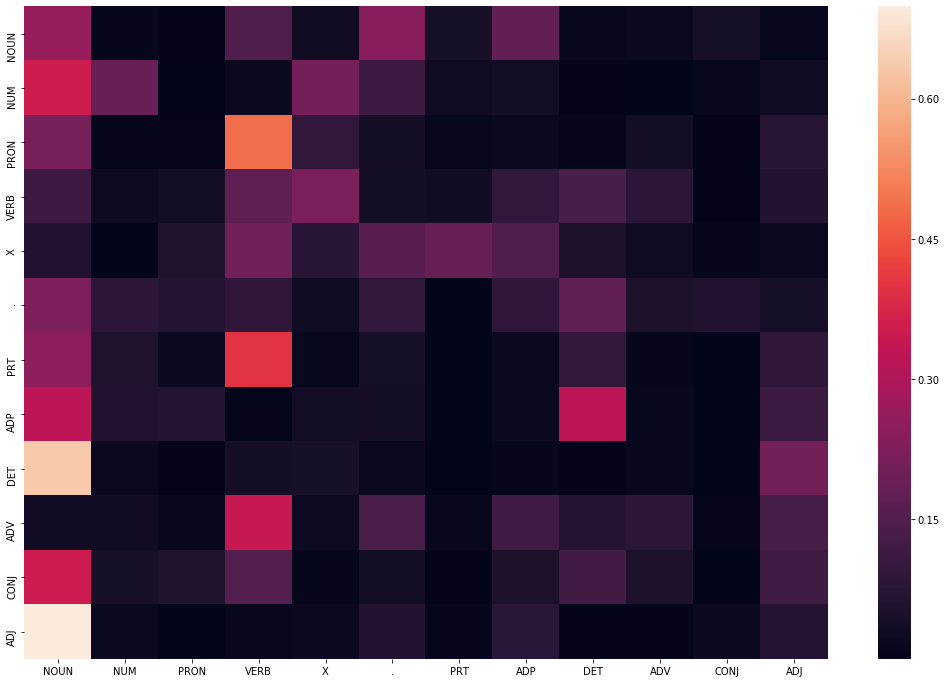

In [22]:
# Heatmap 
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

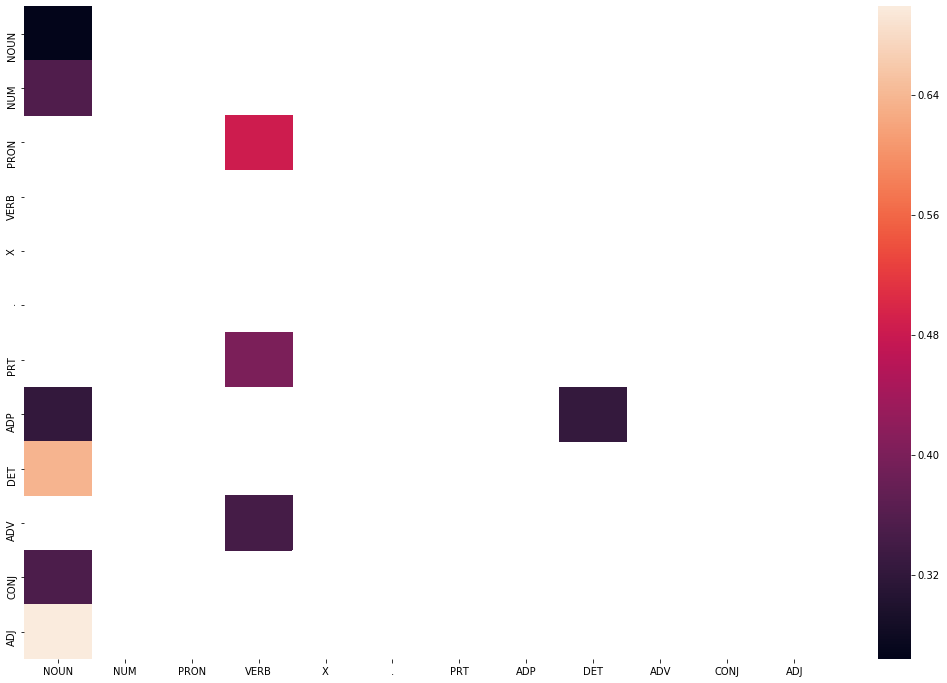

In [23]:
# Calculating frequent tags and filter the df to get P(t2, t1) > 0.25
tags_frequent = tags_df[tags_df>0.25]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [24]:
len(train_tagged_words)

95741

In [26]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [27]:
# Running on entire test dataset would take time
# Taking few sample sentences from test to test Viterbi algorithm

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Williams', 'NOUN'),
  ('shares', 'NOUN'),
  (',', '.'),
  ('which', 'DET'),
  ('*T*-2', 'X'),
  ('were', 'VERB'),
  ('*-2', 'X'),
  ('to', 'PRT'),
  ('be', 'VERB'),
  ('delisted', 'VERB'),
  ('*-1', 'X'),
  ('from', 'ADP'),
  ('the', 'DET'),
  ('New', 'NOUN'),
  ('York', 'NOUN'),
  ('Stock', 'NOUN'),
  ('Exchange', 'NOUN'),
  ('after', 'ADP'),
  ('the', 'DET'),
  ('close', 'NOUN'),
  ('of', 'ADP'),
  ('composite', 'ADJ'),
  ('trading', 'NOUN'),
  ('yesterday', 'NOUN'),
  (',', '.'),
  ('closed', 'VERB'),
  ('at', 'ADP'),
  ('$', '.'),
  ('23.25', 'NUM'),
  ('*U*', 'X'),
  (',', '.'),
  ('off', 'ADV'),
  ('12.5', 'NUM'),
  ('cents', 'NOUN'),
  ('.', '.')],
 [('Terms', 'NOUN'),
  ('were', 'VERB'),
  ("n't", 'ADV'),
  ('disclosed', 'VERB'),
  ('*-1', 'X'),
  ('.', '.')],
 [('The', 'DET'),
  ('screen', 'NOUN'),
  ('shows', 'VERB'),
  ('two', 'NUM'),
  ('distorted', 'ADJ'),
  (',', '.'),
  ('unrecognizable', 'ADJ'),
  ('photos', 'NOUN'),
  (',', '.'),
  ('presumably', 'ADV'),
  ('of', '

In [28]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  25.968316793441772
[('Williams', 'NOUN'), ('shares', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-2', 'X'), ('were', 'VERB'), ('*-2', 'X'), ('to', 'PRT'), ('be', 'VERB'), ('delisted', 'NOUN'), ('*-1', 'X'), ('from', 'ADP'), ('the', 'DET'), ('New', 'NOUN'), ('York', 'NOUN'), ('Stock', 'NOUN'), ('Exchange', 'NOUN'), ('after', 'ADP'), ('the', 'DET'), ('close', 'ADJ'), ('of', 'ADP'), ('composite', 'ADJ'), ('trading', 'NOUN'), ('yesterday', 'NOUN'), (',', '.'), ('closed', 'VERB'), ('at', 'ADP'), ('$', '.'), ('23.25', 'NOUN'), ('*U*', 'X'), (',', '.'), ('off', 'ADP'), ('12.5', 'NUM'), ('cents', 'NOUN'), ('.', '.'), ('Terms', 'NOUN'), ('were', 'VERB'), ("n't", 'ADV'), ('disclosed', 'VERB'), ('*-1', 'X'), ('.', '.'), ('The', 'DET'), ('screen', 'NOUN'), ('shows', 'VERB'), ('two', 'NUM'), ('distorted', 'NOUN'), (',', '.'), ('unrecognizable', 'ADJ'), ('photos', 'NOUN'), (',', '.'), ('presumably', 'NOUN'), ('of', 'ADP'), ('two', 'NUM'), ('politicians', 'NOUN'), ('.', '.'), 

In [30]:
#Finding accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vannila_viterbi_accuracy = len(check)/len(tagged_seq)
vannila_viterbi_accuracy

0.9222222222222223

In [31]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('be', 'VERB'), (('delisted', 'NOUN'), ('delisted', 'VERB'))],
 [('the', 'DET'), (('close', 'ADJ'), ('close', 'NOUN'))],
 [('$', '.'), (('23.25', 'NOUN'), ('23.25', 'NUM'))],
 [(',', '.'), (('off', 'ADP'), ('off', 'ADV'))],
 [('two', 'NUM'), (('distorted', 'NOUN'), ('distorted', 'ADJ'))],
 [(',', '.'), (('presumably', 'NOUN'), ('presumably', 'ADV'))],
 [('how', 'ADV'), (('much', 'ADV'), ('much', 'ADJ'))]]

In [32]:
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
vannila_test_tagged_seq = tagged_seq

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET')

### Solve the problem of unknown words

In [33]:
#Rule Based Tagging with Viterbi
pattern = [
        (r'.*Twitter$', 'NOUN'), 
        (r'.*Android$', 'NOUN'),
        (r'.*Google$', 'NOUN'),
        (r'[-+]?\d*\.\d+|\d+', 'NUM'), # Number with floating values
        (r'.*es$', 'VERB'), 
        (r'.*ing$', 'VERB'), # gerunds or continuous tense
        (r'.*ed$', 'VERB'),  # past perfect tense
        (r'[A-Z ]+', 'NOUN'),  # all caps eg. FIFA, NASA, etc
        (r'.*', 'NOUN'), # default value as NOUN
]

def rule_based_tagging(word, pattern):
    regexp_tagger = nltk.RegexpTagger(pattern)
    kv = regexp_tagger.tag(nltk.word_tokenize(word))
    for v in kv:
        print(word)
        print(v[1])
        return v[1]

In [34]:
# Viterbi Heuristic
def modified_Viterbi_rule_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # computing emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

random.seed(1234)

# Select random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_rule_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)

delisted
VERB
23.25
NUM
distorted
VERB
photos
NOUN
presumably
NOUN
midyear
NOUN
Time taken in seconds:  25.971453428268433
[('Williams', 'NOUN'), ('shares', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-2', 'X'), ('were', 'VERB'), ('*-2', 'X'), ('to', 'PRT'), ('be', 'VERB'), ('delisted', 'VERB'), ('*-1', 'X'), ('from', 'ADP'), ('the', 'DET'), ('New', 'NOUN'), ('York', 'NOUN'), ('Stock', 'NOUN'), ('Exchange', 'NOUN'), ('after', 'ADP'), ('the', 'DET'), ('close', 'ADJ'), ('of', 'ADP'), ('composite', 'ADJ'), ('trading', 'NOUN'), ('yesterday', 'NOUN'), (',', '.'), ('closed', 'VERB'), ('at', 'ADP'), ('$', '.'), ('23.25', 'NUM'), ('*U*', 'X'), (',', '.'), ('off', 'ADP'), ('12.5', 'NUM'), ('cents', 'NOUN'), ('.', '.'), ('Terms', 'NOUN'), ('were', 'VERB'), ("n't", 'ADV'), ('disclosed', 'VERB'), ('*-1', 'X'), ('.', '.'), ('The', 'DET'), ('screen', 'NOUN'), ('shows', 'VERB'), ('two', 'NUM'), ('distorted', 'VERB'), (',', '.'), ('unrecognizable', 'ADJ'), ('photos', 'NOUN'), (',', '.'), ('presumably'

In [35]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
rulebased_modified_viterbi_accuracy = len(check)/len(tagged_seq)
print(rulebased_modified_viterbi_accuracy)

0.9444444444444444


In [36]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('the', 'DET'), (('close', 'ADJ'), ('close', 'NOUN'))],
 [(',', '.'), (('off', 'ADP'), ('off', 'ADV'))],
 [('two', 'NUM'), (('distorted', 'VERB'), ('distorted', 'ADJ'))],
 [(',', '.'), (('presumably', 'NOUN'), ('presumably', 'ADV'))],
 [('how', 'ADV'), (('much', 'ADV'), ('much', 'ADJ'))]]

In [37]:
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_rule_based(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
rulebased_test_tagged_seq = tagged_seq

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NUM
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made

In [38]:
#2 : Rule Based Tagging with Viterbi

def bigram_tagger(wording) :
    t0 = DefaultTagger('NOUN')
    t1 = UnigramTagger(train_set, backoff=t0)
    t2 = BigramTagger(train_set, backoff=t1)
    listvalue=t2.tag(nltk.word_tokenize(wording))
    return listvalue[0][1]

In [39]:
# Viterbi Heuristic
def modified_Viterbi_lexicon_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

random.seed(1234)

#Select random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_lexicon_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)

delisted
VERB
23.25
NUM
distorted
VERB
photos
NOUN
presumably
NOUN
midyear
NOUN
Time taken in seconds:  25.063255548477173
[('Williams', 'NOUN'), ('shares', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-2', 'X'), ('were', 'VERB'), ('*-2', 'X'), ('to', 'PRT'), ('be', 'VERB'), ('delisted', 'VERB'), ('*-1', 'X'), ('from', 'ADP'), ('the', 'DET'), ('New', 'NOUN'), ('York', 'NOUN'), ('Stock', 'NOUN'), ('Exchange', 'NOUN'), ('after', 'ADP'), ('the', 'DET'), ('close', 'ADJ'), ('of', 'ADP'), ('composite', 'ADJ'), ('trading', 'NOUN'), ('yesterday', 'NOUN'), (',', '.'), ('closed', 'VERB'), ('at', 'ADP'), ('$', '.'), ('23.25', 'NUM'), ('*U*', 'X'), (',', '.'), ('off', 'ADP'), ('12.5', 'NUM'), ('cents', 'NOUN'), ('.', '.'), ('Terms', 'NOUN'), ('were', 'VERB'), ("n't", 'ADV'), ('disclosed', 'VERB'), ('*-1', 'X'), ('.', '.'), ('The', 'DET'), ('screen', 'NOUN'), ('shows', 'VERB'), ('two', 'NUM'), ('distorted', 'VERB'), (',', '.'), ('unrecognizable', 'ADJ'), ('photos', 'NOUN'), (',', '.'), ('presumably'

In [40]:
# Finding accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
lexicon_based_viterbi_accuracy = len(check)/len(tagged_seq)
print(lexicon_based_viterbi_accuracy)

incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

0.9444444444444444


[[('the', 'DET'), (('close', 'ADJ'), ('close', 'NOUN'))],
 [(',', '.'), (('off', 'ADP'), ('off', 'ADV'))],
 [('two', 'NUM'), (('distorted', 'VERB'), ('distorted', 'ADJ'))],
 [(',', '.'), (('presumably', 'NOUN'), ('presumably', 'ADV'))],
 [('how', 'ADV'), (('much', 'ADV'), ('much', 'ADJ'))]]

In [41]:
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_lexicon_based(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
lexicon_test_tagged_seq = tagged_seq

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NUM
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made

In [42]:
print("Vannila Viterbi Accuracy: "+ str(vannila_viterbi_accuracy))
print("Lexicon Based Viterbi Accuracy: "+ str(lexicon_based_viterbi_accuracy))
print("Rule Based Viterbi Accuracy: "+ str(rulebased_modified_viterbi_accuracy))

Vannila Viterbi Accuracy: 0.9222222222222223
Lexicon Based Viterbi Accuracy: 0.9444444444444444
Rule Based Viterbi Accuracy: 0.9444444444444444


Lexicon and rule based have higher accuracy compared to Vanilla Viterbi.

Twitter, Android and Google were correctly tagged as Noun in modified Viterbi algorithm
NASA FIFA correctly tagged as Noun
'arriving' and 'invited'  - are the words which are ending with 'ing' and 'ed' are tagged as Verb in Rule based Viterbi algorithm
Words with Integers or float are correctly tagged as NUM
Unknown words 'Google' 'Twitter'are also corrected by Lexicon.